The goal of this notebook is to show you how to build a feature that is ***very*** close to the value of the response, y, at the previous timestep.

This notebook builds chiefly upon the work in these two notebooks:

[https://www.kaggle.com/chenjx1005/two-sigma-financial-modeling/physical-meanings-of-technical-20-30/discussion][1]


[https://www.kaggle.com/luckylwk/two-sigma-financial-modeling/moving-average-macd-analysis][2]


  [1]: https://www.kaggle.com/chenjx1005/two-sigma-financial-modeling/physical-meanings-of-technical-20-30/discussion
  [2]: https://www.kaggle.com/luckylwk/two-sigma-financial-modeling/moving-average-macd-analysis


We can make two conclusions from these:

1) The feature set is shifted. IE the features actually are derived from y(t-1)

2) Many of the features are strongly related to the moving average of of y (or y(t-1) )

To re-iterate these points, in the following code block I load the data set and build some derived quantities from y. In particular I look at the moving averages of y and the moving averages of y(t-1).

I then examine their correlations with the feature set.

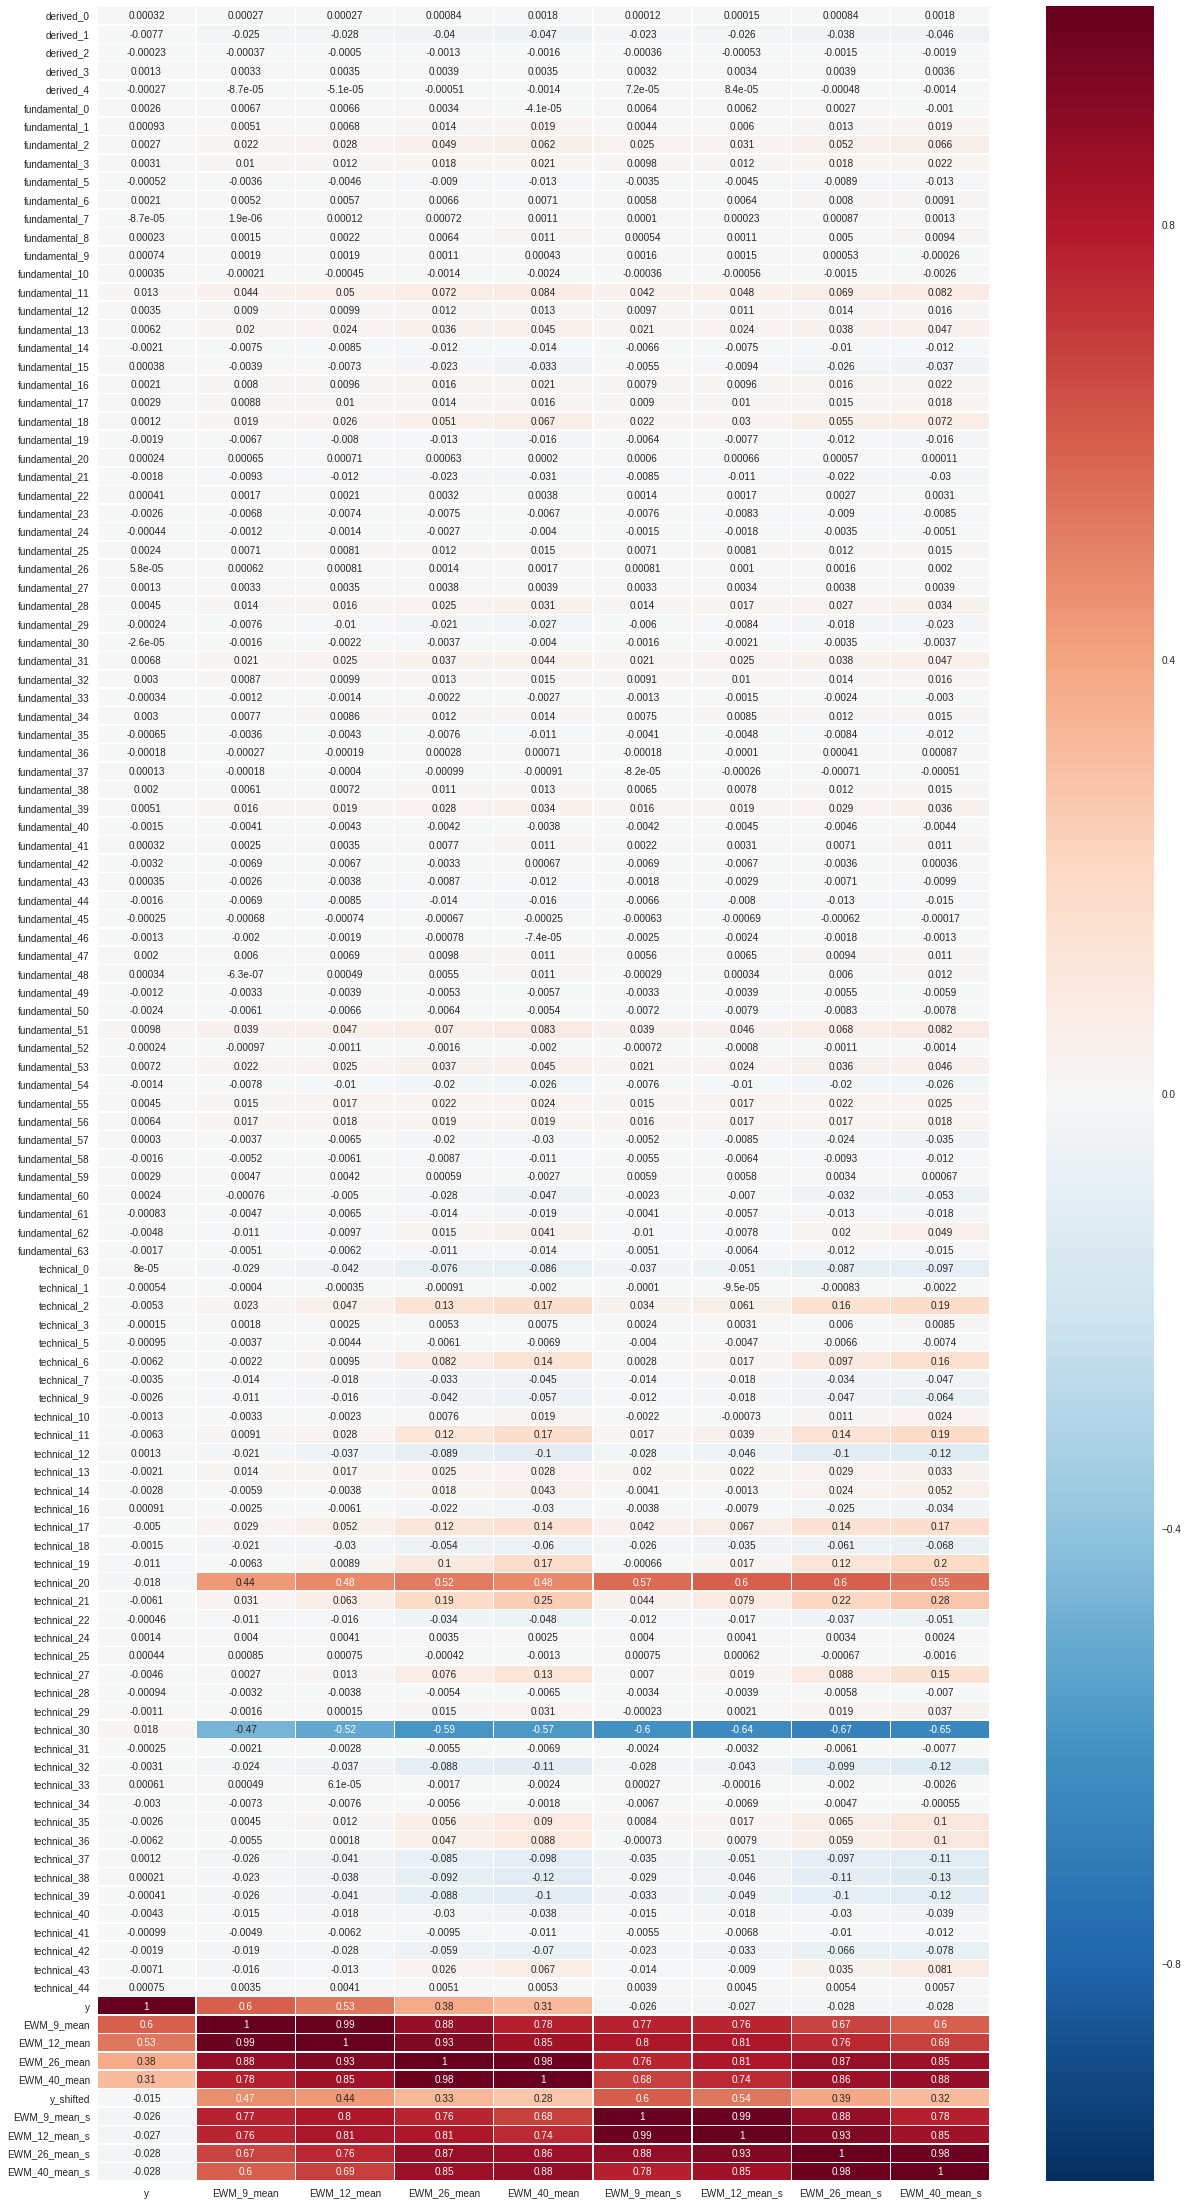

In [1]:
###################################################################
# Import libraries
###################################################################

import kagglegym
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sklearn as sk
from sklearn import preprocessing
from sklearn import cluster
from sklearn import linear_model
from sklearn import ensemble

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

# The "environment" is our interface for code competitions
env = kagglegym.make()

# We get our initial observation by calling "reset"
observation = env.reset()
data_df = observation.train

    
###################################################################
# Get train data frame, do some pre-processing
###################################################################

data = data_df[data_df['timestamp'] < 906]

mean_values = data.mean(axis=0)
data.fillna(mean_values, inplace=True)

train = data[data['timestamp'] < 906/2]
test  = data[data['timestamp'] > 906/2]

# Fill na values
mean_values = test.mean(axis=0)
test.fillna(mean_values, inplace=True)
mean_values = test.mean(axis=0)
train.fillna(mean_values, inplace=True)

def ewm_mean(x,span_in):
    return(x.ewm(span=span_in).mean())

#Build EWM parameters
train['EWM_9_mean']   = train.groupby('id')['y'].apply(lambda x: ewm_mean(x,span_in=9))
train['EWM_12_mean']  = train.groupby('id')['y'].apply(lambda x: ewm_mean(x,span_in=12))
train['EWM_26_mean']  = train.groupby('id')['y'].apply(lambda x: ewm_mean(x,span_in=26))
train['EWM_40_mean']  = train.groupby('id')['y'].apply(lambda x: ewm_mean(x,span_in=40))

test['EWM_9_mean']   = test.groupby('id')['y'].apply(lambda x: ewm_mean(x,span_in=9))
test['EWM_12_mean']  = test.groupby('id')['y'].apply(lambda x: ewm_mean(x,span_in=12))
test['EWM_26_mean']  = test.groupby('id')['y'].apply(lambda x: ewm_mean(x,span_in=26))
test['EWM_40_mean']  = test.groupby('id')['y'].apply(lambda x: ewm_mean(x,span_in=40))

# Build shifted parameters
train['y_shifted']      = train.groupby('id')['y'].shift(1).fillna(0)
train['EWM_9_mean_s']   = train.groupby('id')['y_shifted'].apply(lambda x: ewm_mean(x,span_in=9))
train['EWM_12_mean_s']  = train.groupby('id')['y_shifted'].apply(lambda x: ewm_mean(x,span_in=12))
train['EWM_26_mean_s']  = train.groupby('id')['y_shifted'].apply(lambda x: ewm_mean(x,span_in=26))
train['EWM_40_mean_s']  = train.groupby('id')['y_shifted'].apply(lambda x: ewm_mean(x,span_in=40))

test['y_shifted']      = test.groupby('id')['y'].shift(1).fillna(0)
test['EWM_9_mean_s']   = test.groupby('id')['y_shifted'].apply(lambda x: ewm_mean(x,span_in=9))
test['EWM_12_mean_s']  = test.groupby('id')['y_shifted'].apply(lambda x: ewm_mean(x,span_in=12))
test['EWM_26_mean_s']  = test.groupby('id')['y_shifted'].apply(lambda x: ewm_mean(x,span_in=26))
test['EWM_40_mean_s']  = test.groupby('id')['y_shifted'].apply(lambda x: ewm_mean(x,span_in=40))


# Plot corrilation matrix
cols = [x for x in train.columns if x not in ['id','timestamp']]

main_cols = ['y','EWM_9_mean','EWM_12_mean','EWM_26_mean','EWM_40_mean',
            'EWM_9_mean_s','EWM_12_mean_s','EWM_26_mean_s','EWM_40_mean_s']
main_ix =  train[cols].columns.get_indexer(main_cols)

cor_mat = np.corrcoef(train[cols], rowvar=0)[:,main_ix]

corr_df = pd.DataFrame(cor_mat,columns=main_cols,index=[cols])

plt.figure(figsize=(20,40))
sns.heatmap(corr_df, vmin=-1.0, vmax=1.0, linewidths=.5, annot=True)

Again we see our friends technical_30 and technical_20. In addition some other features appear to also be related to the moving averages. In addition the shifted moving averages are, in general, more strongly correlated to the feature set. 


Now, to "rebuild" y(t-1) I will employ the following strategy.

1) We transform y(t-1) via an exponentially weighted average

2) We build a model to predict the transformed quantity (EWM_26_mean_s) from the feature set, called say EWM_26s_pred

3) We perform an inverse transformation on EWM_26s_pred. We utilize the fact that exponential weighted averages can be computed in an iterative fashion.

That is, S_t = alpha*Y_t +(1-alpha)*S_(t-1)

where S_t is the exponentially weighted average at time t, Y_t is the response at time t, and S_t-1 is the EWA for time t-1

Clearly this equation can be re-arranged to yield

Y_t = (S_t - (1-alpha)*S_(t-1))/alpha



In [2]:
ewm_features = ['technical_30','technical_20','technical_21','technical_19','technical_17','technical_11','technical_2']
my_model = sk.ensemble.GradientBoostingRegressor(loss='ls', max_depth=5, learning_rate=0.05)
my_model.fit(X=train[ewm_features],y=train['EWM_26_mean_s'])
train['EWM_26s_pred'] = my_model.predict(X=train[ewm_features]) 
test['EWM_26s_pred'] = my_model.predict(X=test[ewm_features])

def ewm_reverse(data,span=26):
    alpha = 2/(span+1)
    return (data-(1-alpha)*data.shift(1).fillna(0))/alpha

# Inverse transform
train['yEWM_26'] = train.groupby('id')['EWM_26s_pred'].apply(lambda x: ewm_reverse(x, span=26))
test['yEWM_26'] = test.groupby('id')['EWM_26s_pred'].apply(lambda x: ewm_reverse(x, span=26))

If all went well yEWM_26 should corrispond quite strongly to y(t-1). Lets test it out.

In [3]:
def find_R_value(y_predict,y_actual):
    mean = np.mean(y_actual)
    Rrr = 1 - sum((y_predict-y_actual)**2)/sum((y_actual-mean)**2)
    return np.sign(Rrr)*np.sqrt(np.abs(Rrr))  

find_R_value(test['yEWM_26'],test.groupby('id')['y'].shift(1).fillna(0))

0.80616164791339251

Not bad! Granted it is not perfect as there is some noise in the features, but this might be a decent feature for determining y(t).

For fun, lets look at the plots for a few IDs to see how they match up.

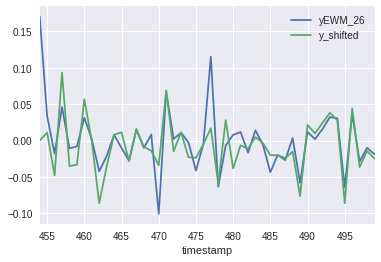

In [4]:
tmp_df = test[(test['timestamp'] < 500) & (test['id'] == test['id'].iloc[10])]
tmp_df.plot(x='timestamp',y=['yEWM_26','y_shifted'])

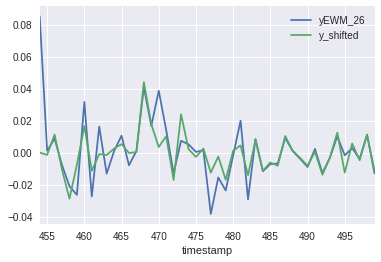

In [5]:
tmp_df = test[(test['timestamp'] < 500) & (test['id'] == test['id'].iloc[1])]
tmp_df.plot(x='timestamp',y=['yEWM_26','y_shifted'])

There is some slight distortion at the start due to how yEWM_26 is calculated, but generally it seems to match quite well.

I think this can prove useful as a feature than can perhaps enable the use of some more conventional time series techniques.

Now, I know what you might be thinking. Why not try this procedure on y(t) instead of y(t-1). Well I have tried this, and surprisingly you get back something that looks more like y(t-1) than y(t).